In [1]:
import helpers as h
import sub_gradient
import qlearning_astar
import numpy as np
import geopandas as gpd
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import networkx as nx

c:\Users\krishn001\AppData\Local\anaconda3\envs\rl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adj_matrix_path = "preprocessed_data/adjacency_matrix_osdpm.txt"
gdf_path = "preprocessed_data/gdf_osdpm_connected_pt.gpkg"
node_dict_path = "preprocessed_data/node_dict_osdpm.pickle"

In [3]:
graph = h.load_adjacency_matrix_safe(adj_matrix_path)
gdf = gpd.read_file(gdf_path)

with open(node_dict_path, 'rb') as f:
        node_dict = pickle.load(f)

In [ ]:
### source and target

origin_lat = 52.350758  #mvp1 - 52.350016
origin_lon = 4.798904    #mvp1 - 4.797826
destination_lat = 52.357348 #mvp1 - 52.362954
destination_lon =4.793762 #mvp1- 4.793823


source, distance = h.find_nearest_node(origin_lat, origin_lon, node_dict)
target, distance = h.find_nearest_node(destination_lat, destination_lon, node_dict)

In [5]:
gdf_viz = gpd.read_file('preprocessed_data/gdf_osdpm_connected.gpkg')

In [6]:
with open('preprocessed_data/graph_osdpm.gpickle', 'rb') as f:
        G = pickle.load(f)

## Sub-gradient

In [ ]:
# creating a dictionary to store lat, lon -- needs to be moved to helpers.py - introduced for turn angle calculation

node_coords = {}


for index, row in gdf.iterrows():
    line = row['geometry'] 
    origin_node = row['origin']
    destination_node = row['destination']
    
    origin_coords = (line.coords[0][0], line.coords[0][1])  
    destination_coords = (line.coords[-1][0], line.coords[-1][1])  
    
    if origin_node not in node_coords:
        node_coords[origin_node] = origin_coords
    if destination_node not in node_coords:
        node_coords[destination_node] = destination_coords


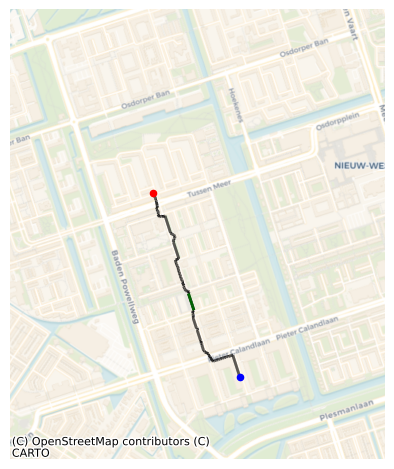

In [ ]:
constraints = [10000, 80, 10000, 10000] # arbitrary constraints

weights = [2,1,1,1] #increase to minimize value

routes = sub_gradient.subgradient_multiple_routes(graph, node_dict ,source, target, constraints, weights ,max_routes=5, max_iter=1000, tol=1e-5)

# path list to gdf and visualisation
fig, ax = plt.subplots()

gdf_viz.plot(ax=ax, color='grey',alpha=0.001)
h.get_route_gdf(routes[0][1], gdf_viz).plot(ax=ax, color='black', linewidth=2, alpha=0.8)
h.get_route_gdf(routes[0][1], gdf_viz[gdf_viz['bike']>0]).plot(ax=ax, color='darkgreen', linewidth=2)
#h.get_route_gdf(nx.shortest_path(G,source, target, 'bike'), gdf_viz).plot(ax=ax, color='grey', linewidth=1.5)
ctx.add_basemap(ax, crs=gdf_viz.crs, source=ctx.providers.CartoDB.Voyager, zoom=15)
#ctx.add_basemap(ax, crs=gdf_viz.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=15)

# Origin and destination location
ax.scatter(node_dict[source][0], node_dict[source][1], color='blue', s=20, zorder=5, label="Source")
ax.scatter(node_dict[target][0], node_dict[target][1], color='red', s=20, zorder=5, label="Source")


route_acc = mpatches.Patch(color='black', label='accessible route (pedestrian)')
route_acc_b = mpatches.Patch(color='darkgreen', label='accessible route (bike)')
route = mpatches.Patch(color='grey', label='shortest route')
origin = mpatches.Patch(color='blue', label= 'origin')
dest = mpatches.Patch(color='red', label= 'destination')
#plt.legend(handles=[route_acc,route_acc_b,route,origin,dest], loc='lower right')
plt.rcParams["legend.fontsize"] = 4

plt.xlim(114000, 115500)
plt.ylim(484600, 486400)
plt.axis('off')
plt.tight_layout()


In [ ]:
walk_bike_connection_sum = h.get_route_gdf(routes[0][1], gdf_viz)['length'].sum() - [h.get_route_gdf(routes[0][1], gdf_viz)['walk'].sum() + h.get_route_gdf(routes[0][1], gdf_viz)['bike'].sum()]
h.get_route_gdf(routes[0][1], gdf_viz)['length'].sum(), h.get_route_gdf(routes[0][1], gdf_viz)['crossing'].sum(), h.get_route_gdf(routes[0][1], gdf_viz)['walk'].sum(), h.get_route_gdf(routes[0][1], gdf_viz)['bike'].sum(), walk_bike_connection_sum[0]

#### Q-learning a star

In [ ]:
G = h.convert_to_multidigraph(gdf)

In [ ]:
weights = {'length': -1, 'crossing': -2, 'bike': 5, 'walk': 3}

# initialize Q-Learning A* class
ql_learner = qlearning_astar.QLearningHeuristicAStar(G, weights, maximize_bike=True)
ql_learner.simulate_random_walks(source, target, num_steps=1)

# path determined using Q-learning-enhanced A*
route = ql_learner.a_star(source, target)

In [ ]:
# path list to gdf and visualisation

h.get_route_gdf(route['path'], gdf).plot()